<h1 align="center">Espécies Ameaçadas de Extinção no Brasil</h1>

<h3>1. Introdução</h3>
<p style="text-align:justify">A Portaria MMA 300/2022 revogou as Portarias 443/2014, 444/2014 e 445/2014, as quais em seua anexos definiam as listas de espécie da flora, fauna e peixes e invertebrados aquáticos ameaçados de extinção no Brasil. Estas listas foram atualizadas e hoje fazem parte da Portaria MMA 300/2022. Os dados aqui utilizados foram obtidos em 14 de dezembro de 2022.</p>
<p style="text-align:justify"></p>
<p style="text-align:justify">O objetivo deste <i>notebook</i> é utilizar a técncia <i>web scraping</i> para extrair as tabelas referentes as espécies da flora, fauna brasileiras ameçadas de extinção, conforme <a href="http://www.in.gov.br/web/dou/-/portaria-gm/mma-n-300-de-13-de-dezembro-de-2022-450425464">Portaria MMA nº 300</a>, de 13 de dezembro de 2022. Para tal utilizaremos a linguagem de programação R</p>

### 2. Import pacotes necessários

In [2]:
# Import libraries
library(rvest)
library(dplyr, warn.conflicts = FALSE)
library(ggplot2)
library(stringr)
library(finch)

### 3. Definição do endereço web

In [3]:
# Set url
url = 'https://www.in.gov.br/en/web/dou/-/portaria-gm/mma-n-300-de-13-de-dezembro-de-2022-450425464'

### 4. Aplicando a técnica _web scraping_

In [4]:
# web scraping the url
tab_lst <- url %>%
        read_html() %>%
        html_nodes(xpath = '//table') %>%
        html_table(header = FALSE)

### 5. Obter informações dos dados

In [5]:
glimpse(tab_lst)

List of 96
 $ : tibble [83 × 5] (S3: tbl_df/tbl/data.frame)
  ..$ X1: chr [1:83] "ANEXO 1. LISTA NACIONAL DE ESPÉCIES DA FLORA AMEAÇADAS DE EXTINÇÃO" "" "1" "2" ...
  ..$ X2: chr [1:83] "ANEXO 1. LISTA NACIONAL DE ESPÉCIES DA FLORA AMEAÇADAS DE EXTINÇÃO" "#" "*" "*" ...
  ..$ X3: chr [1:83] "ANEXO 1. LISTA NACIONAL DE ESPÉCIES DA FLORA AMEAÇADAS DE EXTINÇÃO" "Família" "Acanthaceae" "Acanthaceae" ...
  ..$ X4: chr [1:83] "ANEXO 1. LISTA NACIONAL DE ESPÉCIES DA FLORA AMEAÇADAS DE EXTINÇÃO" "Espécie ou Subespécie/Variedade" "Aphelandra espirito-santensis" "Aphelandra margaritae" ...
  ..$ X5: chr [1:83] "ANEXO 1. LISTA NACIONAL DE ESPÉCIES DA FLORA AMEAÇADAS DE EXTINÇÃO" "Categoria" "EN" "VU" ...
 $ : tibble [3 × 5] (S3: tbl_df/tbl/data.frame)
  ..$ X1: int [1:3] 82 83 84
  ..$ X2: logi [1:3] NA NA NA
  ..$ X3: chr [1:3] "Anacardiaceae" "Anacardiaceae" "Anacardiaceae"
  ..$ X4: chr [1:3] "Schinus ramboi" "Spondiasadmirabilis" "Spondiasbahiensis"
  ..$ X5: chr [1:3] "EN" "EN" "EN"
 $ : tib

In [6]:
length(tab_lst)

[1] 96

In [87]:
# FLORA - lists 1-65
tail(tab_lst[[65]], 10)

n,port443,familia,especie_subespecie_var,categoria
<int>,<chr>,<chr>,<chr>,<chr>
3200,*,Xyridaceae,Xyris retrorsifimbriata,CR
3201,*,Xyridaceae,Xyris rigida,CR
3202,*,Xyridaceae,Xyrissincorana,EN
3203,*,Xyridaceae,Xyris sororia,CR
3204,*,Xyridaceae,Xyrisstenophylla,VU
3205,*,Xyridaceae,Xyris tortilis,CR
3206,*,Xyridaceae,Xyrisuninervis,CR
3207,*,Xyridaceae,Xyris vacillans,EN
3208,*,Xyridaceae,Xyris wawrae,EN


In [85]:
# Fauna - lists 66-95
tail(tab_lst[[95]])

n,port443,ordem,familia,especie_subespecie,categoria
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
5,*,Passeriformes,Furnariidae,Philydor novaesi,EX
6,*,Passeriformes,Icteridae,Leistes defilippii,RE
7,*,Psittaciformes,Psittacidae,Anodorhynchus glaucus,RE
8,*,Strigiformes,Strigidae,Glaucidium mooreorum,EX
,,MAMÍFEROS,MAMÍFEROS,MAMÍFEROS,
9,*,Rodentia,Cricetidae,Noronhomys vespuccii,EX


<p style="text-align=justify">Ao inspercionar os dados podemos verificar que temos uma lista composta por 96 <i>dataframes</i>, sendo que o último é um dado que não faz parte das tabelas da fauna e flora, o que deveremos excluí-lo da lista.</p>
<p style="text-align=justify">Também é possível verificar que os elementos da lista de 1 a 65 são referentes as tabelas da flora, o restante refere-se as espécies da fauna. Os dataframes de flora possuem 5 colunas, enquato que os da fauna 6</p>

In [9]:
# Remove undesirable data
tab_lst[[96]] <- NULL

### 5. Limpeza de dados
<p style="text-alig:justify">Precisamos redefinir os nomes das colunas para os dados de fauna e flora, pois possuem número de colunas diferentes, o que permitira unir todos em um único <i>dataframe</i></p>

In [10]:
# Set column names for each dataframe in a list
for (i in 1:length(tab_lst)) {
    if (length(unlist(attributes(tab_lst[[i]])[2])) == 5) {
        names(tab_lst[[i]]) <- c('n', 'port443', 'familia',
                                 'especie_subespecie_var', 
                                 'categoria')
    }
    else {
        if (length(unlist(attributes(tab_lst[[i]])[2])) == 6) {
            names(tab_lst[[i]]) <- c('n', 'port443', 'ordem',
                                   'familia', 'especie_subespecie', 
                                   'categoria')
        }
    }
}

# Check attributes       
names(tab_lst[[1]])  # flora
names(tab_lst[[94]]) # fauna

[1] "n"                      "port443"                "familia"               
[4] "especie_subespecie_var" "categoria"

[1] "n"                  "port443"            "ordem"             
[4] "familia"            "especie_subespecie" "categoria"

### 5.1 Extrair apenas os dados referentes à flora e salvá-los em planilha csv

In [11]:
# Subset the flora dataframes in the list
df_list <- tab_lst[1:65]

# Loop over the list to merge all flora dataframes in a single dataframe
for (i in 1:65) {
    
    df_list[[i]][1] <- NULL
    df <- bind_rows(df_list)
    df <- df[c(-1, -2), c(1:4)]
    df <- df %>% 
        tibble::rowid_to_column(var = 'n')
    
    df <- df[complete.cases(df), ]
    
    write.csv2(
        df, './port_mma300_2022_flora.csv', 
        row.names = FALSE)
    
}

<p style="text-align:justify">Chama atenção o fato de muitas espécies, tanto da flora quanto da fauna, estarem com a grafia do nome científico errado, a exemplo de <i>Vochysia gummifera</i>, a qual está grafada como <i>Vochysiagummifera</i>, o que pode induzir o público leigo a erros quando busca por expécies ameaçadas. O trecho de código abaixo mostra o número total de espécies da flora que apresentam erro grave de grafia.</p>

In [104]:
df_flora <- read.csv2('./port_mma300_2022_flora.csv', fileEncoding = 'UTF-8')

nomes_incorretos <- df_flora %>%
        mutate(especie_subespecie_var = tolower(especie_subespecie_var)) %>%
        mutate(especie_subespecie_var = R.utils::capitalize(especie_subespecie_var)) %>%
        mutate(especie_subespecie_var = str_trim(especie_subespecie_var)) %>%
        mutate(especie_subespecie_var = str_squish(especie_subespecie_var)) %>%
        filter(!especie_subespecie_var %in% str_extract(especie_subespecie_var, '(\\b\\w+\\s\\w+\\b)')) %>%
        filter(!especie_subespecie_var %in% str_extract(especie_subespecie_var, '(\\b\\w+\\s\\w+\\s\\w+\\b)')) %>%
        filter(!especie_subespecie_var %in% str_extract(especie_subespecie_var, '(\\b\\w+\\s\\w+-\\w+\\b)'))

dim(nomes_incorretos)[1]

[1] 1864

### 5.2 Correção dos Nomes Científicos
<p style="text-align:justify">Para corrigir os erros de grafia nos 1.864 nomes científicos, usaremos como referência a lista de espécies do projeto <a href="https://reflora.jbrj.gov.br/reflora">REFLORA, cuja base de dados encontra-se no <a href="http://ipt.jbrj.gov.br/jbrj/archive.do?r=lista_especies_flora_brasil&v=393.291">site do jardim botânico do Rio de Janeiro</a></p>

In [106]:
# nomes corretos
correto <- df_flora %>%
        anti_join(nomes_incorretos, by = 'especie_subespecie_var')

# Reflora
reflora <- read.csv2('./reflora20210929.csv',
                     fileEncoding = 'UTF-8') %>%
        mutate(especie_subespecie_var = paste0(genus, specificEpithet)) %>%
        select(specie, especie_subespecie_var)
        

nomes_corrigidos <- reflora %>%
        inner_join(df_flora, by = 'especie_subespecie_var') %>%
        select(-2) %>%
        rename(especie_subespecie_var = specie) %>%
        select(2:3, 1, 4, 5)

df <- rbind(correto, nomes_corrigidos)

# epecies faltantes
nomes_ainda_incorretos <- df_flora %>%
        anti_join(df, by = 'n')

df_fim <- rbind(df, nomes_ainda_incorretos)

# salvar como csv
write.csv2(df_fim, './port_MMA_300-2022_flora_lista_definitiva.csv', row.names = FALSE)

## 5.4 Consultar todas as Espécies dos Gêneros _Manilkara_ e _Vochysia_

In [93]:
# Consultas
df_fim %>%
        filter(especie_subespecie_var == str_extract(especie_subespecie_var, '(^Manilkara\\s\\w+)*'))

df_fim %>%
        filter(especie_subespecie_var == str_extract(especie_subespecie_var, '(^Vochysia\\s\\w+)*'))

n,port443,familia,especie_subespecie_var,categoria
<int>,<chr>,<chr>,<chr>,<chr>
2987,*,Sapotaceae,Manilkara maxima,EN
2985,*,Sapotaceae,Manilkara dardanoi,CR
2986,*,Sapotaceae,Manilkara decrescens,VU


n,port443,familia,especie_subespecie_var,categoria
<int>,<chr>,<chr>,<chr>,<chr>
3168,,Vochysiaceae,Vochysia eximia,VU
3169,,Vochysiaceae,Vochysia expansa,VU
3176,,Vochysiaceae,Vochysia rufescens,VU
3180,,Vochysiaceae,Vochysia talmonii,CR
3165,*,Vochysiaceae,Vochysia angelica,EN
3165,*,Vochysiaceae,Vochysia angelica,EN
3165,*,Vochysiaceae,Vochysia angelica,EN
3170,,Vochysiaceae,Vochysia glazioviana,EN
3170,,Vochysiaceae,Vochysia glazioviana,EN


### 6. Análise dos dados de flora

## 6.1 Famílias da Flora Mais Ameaçadas

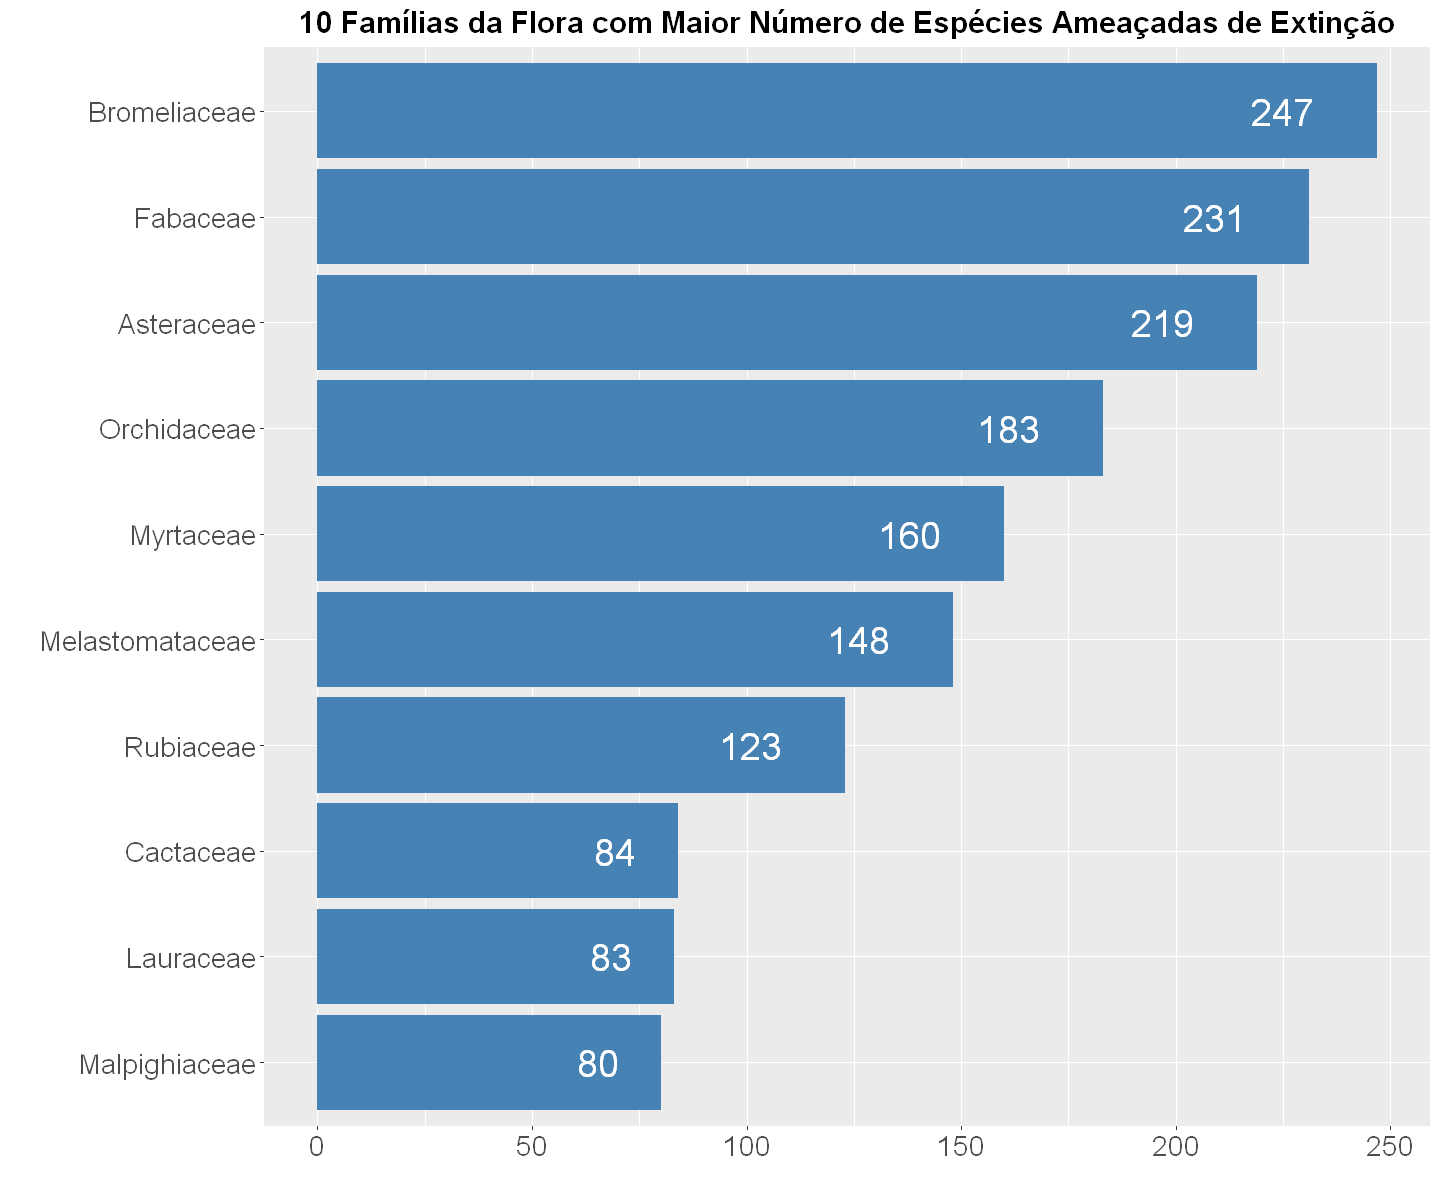

In [20]:
# Set figure size
options(repr.plot.width = 12, repr.plot.height = 10)

statusFamily <- df_fim %>%
        #filter(familia != "") %>%
        count(familia, sort = TRUE) %>%
        slice_max(n, n = 10)

statusFamily$familia <- with(statusFamily, reorder(familia, n))

ggplot(statusFamily, aes(familia, n)) +
        geom_col(fill = 'steelblue') + coord_flip() +
        geom_text(aes(label = n, hjust = 2), color = 'white', size = 8) +
        my_theme +
        labs(
                title = '10 Famílias da Flora com Maior Número de Espécies Ameaçadas de Extinção',
                x = '',
                y = ''
            )

## 6.2 Resumo dos Dados da Flora Por Categoria de Ameaça

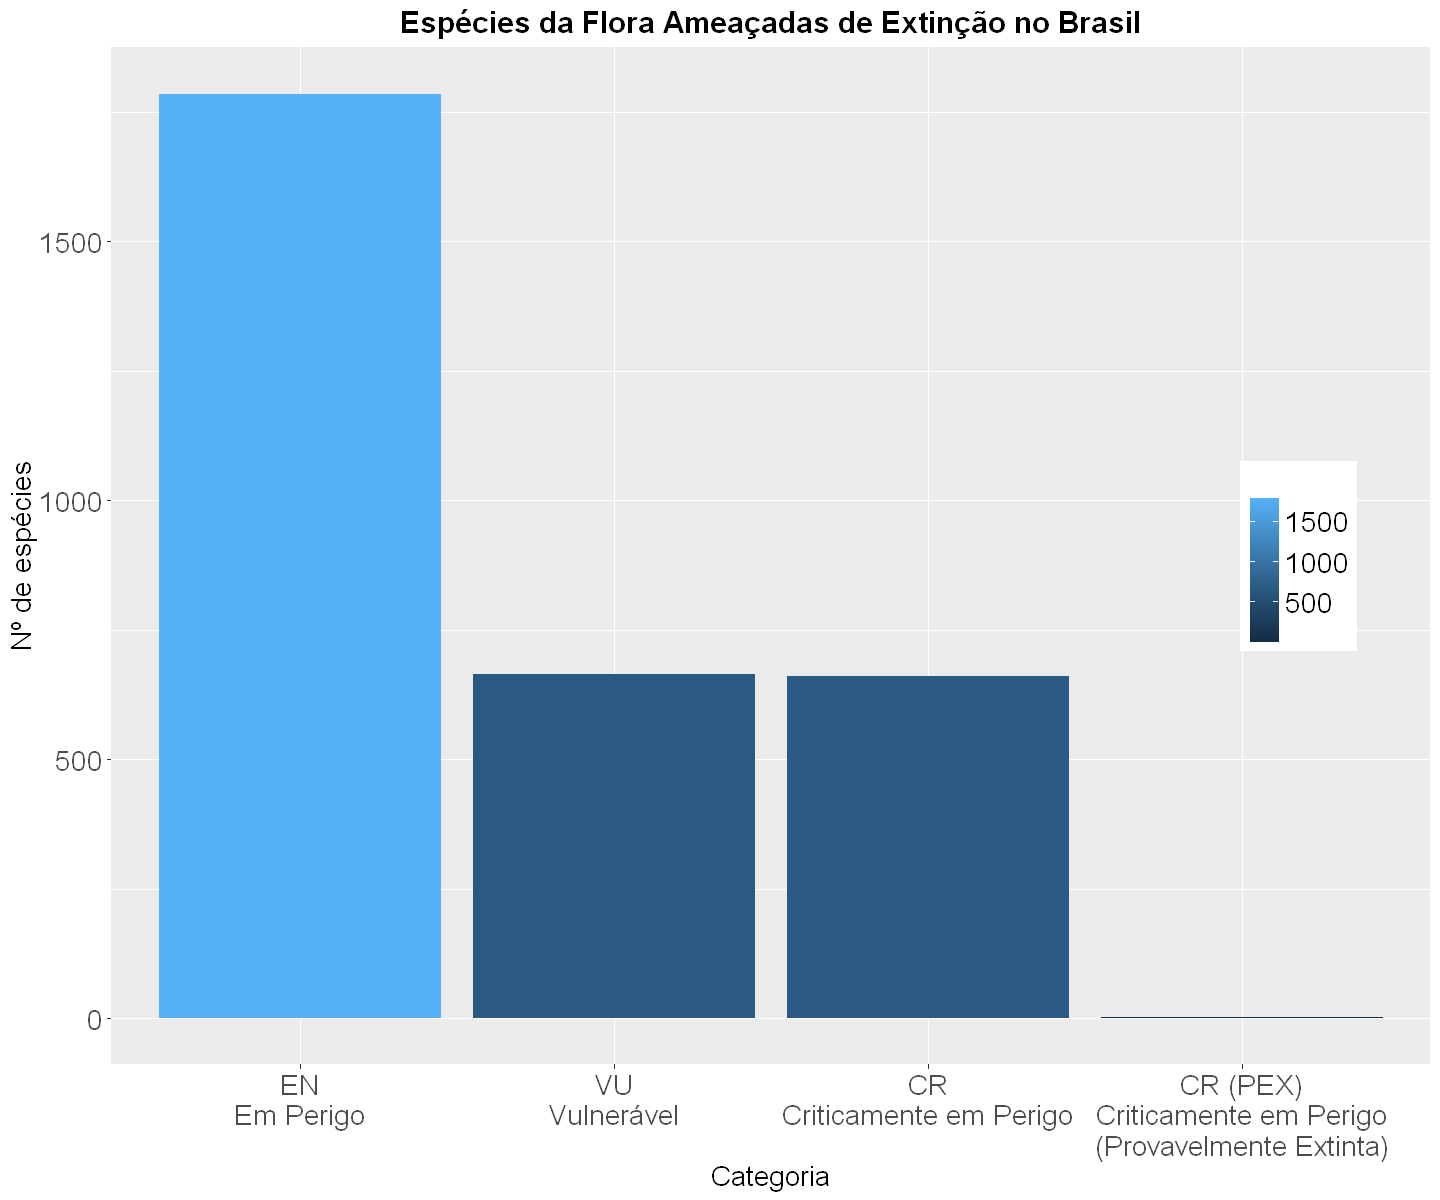

In [19]:
# Set theme to the plots
my_theme <- theme(plot.title = element_text(hjust = 0.5, size = 18, face = 'bold'),
          axis.title = element_text(size = 17),
          axis.text = element_text(size = 17),
          legend.text = element_text(size = 17),
          legend.position = c(0.9, 0.5))

# Set status dataframe
species_status <- df_fim %>%
        group_by(categoria) %>%
        count(categoria, sort = TRUE)

# Reorder status dataframe by "n" and "categoria" columns
species_status$categoria <- with(species_status, 
                                 reorder(categoria, n, decreasing = TRUE))

# Legend
labels <- c('EN\nEm Perigo', 'VU\nVulnerável', 'CR\nCriticamente em Perigo', 
            'CR (PEX)\nCriticamente em Perigo\n(Provavelmente Extinta)')

status_cod <- c('EN' , 'VU', 'CR' , 'CR (PEX)')

# Status plot        
ggplot(species_status, aes(x = categoria, y = n, fill = n)) +
    geom_col() +
    my_theme +
    scale_x_discrete(limits = status_cod, labels = labels) +
    labs(
            title = 'Espécies da Flora Ameaçadas de Extinção no Brasil',
            x = 'Categoria',
            y = 'Nº de espécies',
            fill = ''
    )

In [107]:
# Portaria MMA 443
port443 <- read.csv('D:/data/jbrio/port443.csv')

df_flora <- data.frame(Portaria_443 = nrow(port443),
                       Portaria_300 = nrow(df_fim),
                       Diferença = (nrow(df_fim) - nrow(port443)))

as_tibble(df_flora)

Portaria_443,Portaria_300,Diferença
<int>,<int>,<int>
2113,3831,1718


<p style="text-align=justify">Podemos observar que houve um acrescimo de 1.718 novas espécies ameaçadas de extinção para a flora brasileira.</p>

In [100]:
reflora <- read.csv2('./reflora20210929.csv',
                     fileEncoding = 'UTF-8')

# Sinonimos
sinonimos_flora <- reflora %>%
rename(especie_subespecie_var = specie) %>%
inner_join(df_fim, by = 'especie_subespecie_var') %>%
filter(taxonomicStatus == 'SINONIMO')

# Salvar como csv
write.csv2(sinonimos_flora, './port_MMA_300-2022_flora_sinonimos.csv', row.names = FALSE)

# Mostrar número de linhas
dim(sinonimos_flora)[1]

[1] 25

<p style="text-align:justify">Ao comparar a lista da Portaria MMA 300/2022 com a lista de espécies do projeto REFLORA, foi obervado que há 25 nomes cientificos com grafia de sinônimo taxonômico</p>

In [99]:
sinonimos_flora %>%
    select(n, especie_subespecie_var, acceptedNameUsage, categoria)

n,especie_subespecie_var,acceptedNameUsage,categoria
<int>,<chr>,<chr>,<chr>
2821,Coussarea viridis,Faramea calyciflora,EN
2871,Psychotria microcarpa,Palicourea minutiflora,EN
2900,Rudgea vellerea,Simira rubra,VU
2813,Coussarea ampla,Coussarea hydrangeifolia,VU
1298,Croton leptobotryus,Croton fulvus,VU
2460,Grobya cipoensis,Gomesa ramosa,CR
2810,Chomelia tristis,Chomelia brasiliana,EN
2866,Psychotria clavipes,Psychotria rhytidocarpa,EN
2410,Cattleya purpurata,Cattleya purpurata,VU


## 6.3 Quais das Espécies Ameçadas da Flora São de Interesse Madeireiro?
Para saber as espécies de interesse madeireiro, utilizamos como referência os dados do Sistema Nacional de Controle da Origem dos Produtos Florestais (SINAFLOR). Os dados são referentes as autorizações emitidas para Planos de Manejo Florestal Sustentáveis em 2022.

In [108]:
# Especies Madeireiras SINAFLOR
sinaflor <- read.csv2('./sinaflor_autorizacoes_pmfs_2022.csv')

sp_mad <- sinaflor %>%
        mutate(especie = stringr::str_trim(Nome.científico)) %>%
        mutate(especie = stringr::str_squish(Nome.científico))

# join
lista_sp_mad_amecada <- sp_mad %>%
        left_join(df_fim, by = c('especie' = 'especie_subespecie_var')) %>%
        filter(!is.na(port443)) %>%
        rename(nome_vernacular_SFB = Nome.vulgar, especie_SFB = especie) %>%
        select(-n)

In [109]:
# número de espécies madeireiras ameaçadas de extinção
dim(lista_sp_mad_amecada)[1]

[1] 37

In [111]:
head(lista_sp_mad_amecada, 37)

,nome_vernacular_SFB,especie_SFB,port443,familia,categoria
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Cerejeira,Amburana cearensis,*,Fabaceae,VU
2,Pinheiro-do-paraná,Araucaria angustifolia,*,Araucariaceae,EN
3,Pinheiro-do-paraná,Araucaria angustifolia,*,Araucariaceae,EN
4,Pinheiro-do-paraná,Araucaria angustifolia,*,Araucariaceae,EN
5,Pinheiro-do-paraná,Araucaria angustifolia,*,Araucariaceae,EN
6,Pinheiro-do-paraná,Araucaria angustifolia,*,Araucariaceae,EN
7,Pinheiro-do-paraná,Araucaria angustifolia,*,Araucariaceae,EN
8,Castanheira,Bertholletia excelsa,*,Lecythidaceae,VU
9,Jacarandá-da-bahia,Dalbergia nigra,*,Fabaceae,VU


## 7. Dados Referentes à Fauna

## 7.1 Extrair apenas os dados referentes à fauna e salvá-los em planilha csv

In [21]:
# Subset the flora dataframes in the list
df_list_fauna <- tab_lst[66:95]
    
#df_list_fauna <- lapply(df_list_fauna, function(x) { x[!is.na(x)] })
    
df_fauna <- purrr::reduce(df_list_fauna, rbind)
df_fauna <- df_fauna[c(-1, -2), ]     

write.csv2(
    df_fauna, './port_mma300_2022_fauna.csv', 
    row.names = FALSE,
    fileEncoding = 'latin1')

In [22]:
print(head(df_fauna))
print(tail(df_fauna))

# A tibble: 6 × 6
  n     port443 ordem                    familia      especie_subespe… categoria
  <chr> <chr>   <chr>                    <chr>        <chr>            <chr>    
1 ""    ""      INVERTEBRADOS TERRESTRES INVERTEBRAD… INVERTEBRADOS T… ""       
2 "1"   "*"     Amblypygi                Charinidae   Charinus acaraje "VU"     
3 "2"   "*"     Amblypygi                Charinidae   Charinus asturi… "EN"     
4 "3"   ""      Amblypygi                Charinidae   Charinus caatin… "CR"     
5 "4"   "*"     Amblypygi                Charinidae   Charinus eleono… "EN"     
6 "5"   ""      Amblypygi                Charinidae   Charinus ferreus "CR"     
# A tibble: 6 × 6
  n     port443 ordem          familia     especie_subespecie    categoria
  <chr> <chr>   <chr>          <chr>       <chr>                 <chr>    
1 "5"   "*"     Passeriformes  Furnariidae Philydor novaesi      "EX"     
2 "6"   "*"     Passeriformes  Icteridae   Leistes defilippii    "RE"     
3 "7"   "*"     

## 7.2 Correção dos Nomes Científicos da Fauna 

<p style="text-align:justify">Asssim como nas tabelas da flora, as da fauna também apresentam erros de grafia nos nomes científico, conforme mostrado na saída do código abaixo.</p>

In [23]:
df_fauna <- read.csv2('./port_mma300_2022_fauna.csv', fileEncoding = 'latin1')
df_fauna[is.na(str_extract(df_fauna$especie_subespecie, '(\\w+\\s\\w+)')), ]

,n,port443,ordem,familia,especie_subespecie,categoria
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
20,19,*,Araneae,Ochyroceratidae,Ochyroceraibitipoca,EN
28,27,*,Araneae,Theraphosidae,Dolichothelediamantinensis,EN
30,29,*,Araneae,Theraphosidae,Tmesiphanteshypogeus,CR
32,31,*,Araneae,Theraphosidae,Typhochlaenaseladonia,EN
33,32,*,Araneae,Theraphosidae,Ybyraporadiversipes,EN
38,37,,Coleoptera,Carabidae,Coarazuphiumamazonicus,CR
41,40,*,Coleoptera,Carabidae,Coarazuphiumformoso,CR
44,43,,Coleoptera,Carabidae,Coarazuphiumspinifemur,CR
47,46,*,Coleoptera,Carabidae,Schizogeniusocellatus,EN


O código abaixo mostra que foram publicados 235 nomes científicos da fauna de forma incorreta.

In [ ]:
sum(is.na(str_extract(df_fauna$especie_subespecie, '\\w+\\s\\w+')))

Para correção dos nomes científicos da fauna foram utilizados os dados do _[Global Biodiversity Information Facility](https://www.gbif.org/)_.

In [ ]:
# Tabela Fauna GBIF
gbif <- readRDS('./Portaria_MMA_300-2022/gbif_clean.rds')

In [ ]:
port300_fauna <- df_fauna %>%
        mutate(especie_subespecie = tolower(especie_subespecie)) %>%
        mutate(especie_subespecie = R.utils::capitalize(especie_subespecie)) %>%
        mutate(especie_subespecie = str_trim(especie_subespecie)) %>%
        mutate(especie_subespecie = str_squish(especie_subespecie))

In [ ]:
# Nomes incorretos
port300_fauna_erro <- port300_fauna %>%
        filter(!especie_subespecie %in% str_extract(especie_subespecie,
                                                    '(\\b\\w+\\s\\w+\\b)')) %>%
        filter(!especie_subespecie %in% str_extract(especie_subespecie,
                                                    '(\\b\\w+\\s\\w+\\s\\w+\\b)'))

In [ ]:
# Join
tbl_join_fauna <- fuzzyjoin::stringdist_inner_join(port300_fauna_erro, gbif,
                                           by = c('especie_subespecie' = 'especie_GBIF'),
                                           ignore_case = TRUE,
                                           distance_col = 'distance')

# Novo dataframe com os dados processados
df <- port300_fauna %>%
        left_join(tbl_join_fauna, by = 'especie_subespecie')

## 7.3 Definição das Classes Taxonômicas para as Espécie da Fauna
A obtenção das classes taxômicas foi realizada através dos dados obtidos no site do projeto _The Interim Register of Marine and Nonmarine Genera_ - [IRMNG](https://www.irmng.org/download.php)

In [24]:
taxon <- readRDS('./taxon_animalia.rds') %>%
    mutate(family = str_trim(family))

glimpse(taxon)

Rows: 111,436
Columns: 31
$ taxonID                  <chr> "urn:lsid:irmng.org:taxname:2", "urn:lsid:irm…
$ scientificNameID         <chr> "urn:lsid:irmng.org:taxname:2", "urn:lsid:irm…
$ acceptedNameUsageID      <chr> "urn:lsid:irmng.org:taxname:2", "urn:lsid:irm…
$ parentNameUsageID        <chr> "urn:lsid:irmng.org:taxname:1", "urn:lsid:irm…
$ namePublishedInID        <chr> "", "", "", "https://doi.org/10.1007/bf014889…
$ scientificName           <chr> "Animalia", "Agmata", "Brachiopoda", "Chitino…
$ acceptedNameUsage        <chr> "Animalia", "Agmata", "Brachiopoda", "Chitino…
$ parentNameUsage          <chr> "Biota", "Animalia", "Animalia", "Animalia", …
$ namePublishedIn          <chr> "", "", "", "Eisenack, A. (1931). Neue mikrof…
$ namePublishedInYear      <chr> "", "", "", "1931", "", "", "", "1998", "2000…
$ kingdom                  <chr> "Animalia", "Animalia", "Animalia", "Animalia…
$ phylum                   <chr> "", "Agmata", "Brachiopoda", "Chitinozoa", "C…
$ class       

In [25]:
df_fauna <- read.csv2('./port_MMA_300-2022_fauna_final.csv', fileEncoding = 'latin1')
glimpse(df_fauna)

Rows: 1,282
Columns: 6
$ n                  <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, …
$ port443            <chr> "*", "*", "*", "*", "*", "*", "*", "*", "*", "", "*…
$ ordem              <chr> "Accipitriformes", "Accipitriformes", "Accipitrifor…
$ familia            <chr> "Accipitridae", "Accipitridae", "Accipitridae", "Ac…
$ especie_subespecie <chr> "Amadonastur lacernulatus", "Circus cinereus", "Har…
$ categoria          <chr> "VU", "VU", "VU", "EN", "VU", "EN", "EN", "VU", "EN…


In [26]:
# Obter registros duplicados e removê-los
nomes_duplicados <- df_fauna %>%
    count(especie_subespecie, name = 'cnt') %>%
    filter(cnt > 1)

head(nomes_duplicados)
dim(nomes_duplicados)

,especie_subespecie,cnt
,<chr>,<int>
1,Callicebus personatus,2
2,Cichlopsis leucogenys,5
3,Coryphistera alaudina,3
4,Herpailurus yagouaroundi,4
5,Hyphessobrycon flammeus,2
6,Thalasseus acuflavidus,4


[1] 7 2

In [27]:
# Lista sem nomes duplicados
nrow(filter(df_fauna, !duplicated(especie_subespecie)))

[1] 1266

In [28]:
df_fauna_fim <- taxon %>%
    select(family, class) %>%
    left_join(df_fauna, by = c('family' = 'familia')) %>%
    tidyr::drop_na() %>%
    rename(familia = family, classe = class) %>%
    select(c(3, 4, 2, 5, 1, 6, 7)) %>%
    filter(!duplicated(especie_subespecie))

In [29]:
head(df_fauna_fim)
dim(df_fauna_fim)

,n,port443,classe,ordem,familia,especie_subespecie,categoria
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,978,*,Arachnida,Pseudoscorpiones,Chthoniidae,Pseudochthonius biseriatus,EN
2,108,*,Arachnida,Araneae,Ctenidae,Celaetycheus mungunza,CR
3,109,*,Arachnida,Araneae,Ctenidae,Isoctenus corymbus,CR
4,261,*,Insecta,Coleoptera,Dytiscidae,Copelatus cessaima,EN
5,274,*,Insecta,Coleoptera,Lucanidae,Altitatiayus campoi,VU
6,275,*,Insecta,Coleoptera,Lucanidae,Altitatiayus dulceae,VU


[1] 1210    7

<p style="text-align:justify">A lista completa da fauna contém 1.266 espécies, porém, após a junção com os dados de classe da tabela do IRMNG observa-se que a lista passou a ter 1.210 espécies, indicando que na tabela de referência para obtenção das classes taxonômicas não existem 56 espécies da lista em questão e/ou que a lista foi gerado com nomes duplicados.</p>
    
<p style="text-align:justify">Para resolver esse problema utilizaremos o pacote <i>taxize</i>, o qual permite consultar nomes científicos em diferentes bases de dados sobre biodiversidade no mundo, a exemplo da base de do <i>Integrated Taxonomic Information System</i><a href="https://itis.gov/"> - ITS</a> e <i>The National Center for Biotechnology Information</i><a href="https://www.ncbi.nlm.nih.gov/"> - NCBI.</a> Não utilizamos este pacote desde op começo da análise em função do tempo de processamento necessário ser muito longo para a lista ora sob análise.</p>

In [30]:
nomes_sem_classe <- df_fauna %>%
    anti_join(df_fauna_fim, by = 'familia')

In [31]:
# Obter número de linhas e colunas
dim(nomes_sem_classe)

[1] 56  6

Para ganhar desempenho no processamento da busca nos dados do ITS e NCBI, utilizaremos apenas as espécies que não possuem associação coma os dados do IRMNG.

In [ ]:
classes <- nomes_sem_classe %>%
        # Busca as classes taxonômicas na base de dados do ITS utilizando a família como parâmetro
        mutate(classe = taxize::tax_name(familia, get = "class", db = 'itis')$class) %>%
        # Busca as classes taxonômicas na base de dados do NCBI utilizando a família como parâmetro
        mutate(classe = if_else(is.na(classe), 
                                taxize::tax_name(familia, get = "class", db = 'ncbi')$class, 
                                classe)) %>%
        select(c(1, 2, 7, 3:6))

In [33]:
dim(classes)

[1] 56  7

Após as buscas em duas bases de dados, apenas 27 espécies ficaram sem a correspondente classe taxonômica, como podemos observar na saída do código abaixo.

In [34]:
summary(is.na(classes$classe))

   Mode   FALSE    TRUE 
logical      29      27 

De posse da maioria das classes das espécies da fauna, faremos a junção dos _dataframes_ _df_fauna_ e _classes_ para salvar os dados definitivos em uma planilha csv. Entretano, antes de salvarmos a lista definitiva, vamos ferificar quais espécies estão sem classe taxonômica e tentar obtê-las manualmente.

In [35]:
# Junção dos dataframes
df <- rbind(classes, df_fauna_fim)

# ordenar os dados pela coluna "n"
df <- df %>%
    arrange(n)

In [36]:
df[is.na(df$classe), ]

,n,port443,classe,ordem,familia,especie_subespecie,categoria
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
506,513,*,NA,Glomeridesmida,Glomerodesmidae,Glomeridesmus spelaeus,EN
735,746,,NA,Passeriformes,Onychorhynchidae,Onychorhynchusswainsoni,VU
743,754,*,NA,Passeriformes,Platyrinchidae,Calyptura cristata,CR (PEX)
744,755,,NA,Passeriformes,Platyrinchidae,Platyrinchus leucoryphus,VU
745,756,*,NA,Passeriformes,Platyrinchidae,Platyrinchus mystaceus niveigularis,VU
752,763,,NA,Passeriformes,Rhynchocyclidae,Cnipodectessuperrufus,VU
753,764,*,NA,Passeriformes,Rhynchocyclidae,Hemitriccus kaempferi,VU
754,765,*,NA,Passeriformes,Rhynchocyclidae,Hemitriccus mirandae,EN
755,766,*,NA,Passeriformes,Rhynchocyclidae,Phylloscartes beckeri,EN


A saída do código acima mostra que as espécies sem a classe taxonômica pertencem as famílias:

In [37]:
cat(glue::glue_collapse(unique(nomes_sem_classe$familia), sep = ', ', last = ' e '))

Aromobatidae, Cycloramphidae, Hylodidae, Odontophrynidae, Glomerodesmidae, Kimulidae, Grallariidae, Onychorhynchidae, Platyrinchidae, Rhynchocyclidae, Scleruridae, Tityridae, Xenopidae, Epinephelidae, Liolaemidae, Mabuyidae, Phyllodactylidae e Sphaerodactylidae

In [38]:
df[df$familia=='Aromobatidae', 'classe'] <- 'Diplopoda'
df[df$familia=='Cycloramphidae', 'classe'] <- 'Amphibia'
df[df$familia=='Hylodidae', 'classe'] <- 'Amphibia'
df[df$familia=='Odontophrynidae', 'classe'] <- 'Amphibia'
df[df$familia=='Odontophrynidae', 'classe'] <- 'Amphibia'
df[df$familia=='Kimulidae', 'classe'] <- 'Arachnida'
df[df$familia=='Grallariidae', 'classe'] <- 'Aves'
df[df$familia=='Onychorhynchidae', 'classe'] <- 'Aves'
df[df$familia=='Platyrinchidae', 'classe'] <- 'Aves'
df[df$familia=='Scleruridae', 'classe'] <- 'Aves'
df[df$familia=='Tityridae', 'classe'] <- 'Aves'
df[df$familia=='Xenopidae', 'classe'] <- 'Aves'
df[df$familia=='Epinephelidae', 'classe'] <- 'Atheriniformes'
df[df$familia=='Liolaemidae', 'classe'] <- 'Reptilia'
df[df$familia=='Mabuyidae', 'classe'] <- 'Reptilia'
df[df$familia=='Phyllodactylidae', 'classe'] <- 'Reptilia'
df[df$familia=='Sphaerodactylidae', 'classe'] <- 'Reptilia'

In [250]:
# salvar como csv
write.csv2(df, './port_MMA_300-2022_fauna_lista_definitiva.csv',
           row.names = FALSE, 
           fileEncoding = 'latin1')

## 7.4 Quais Classes Taxonômicas são mais Ameaçadas na Fauna Brasileira 

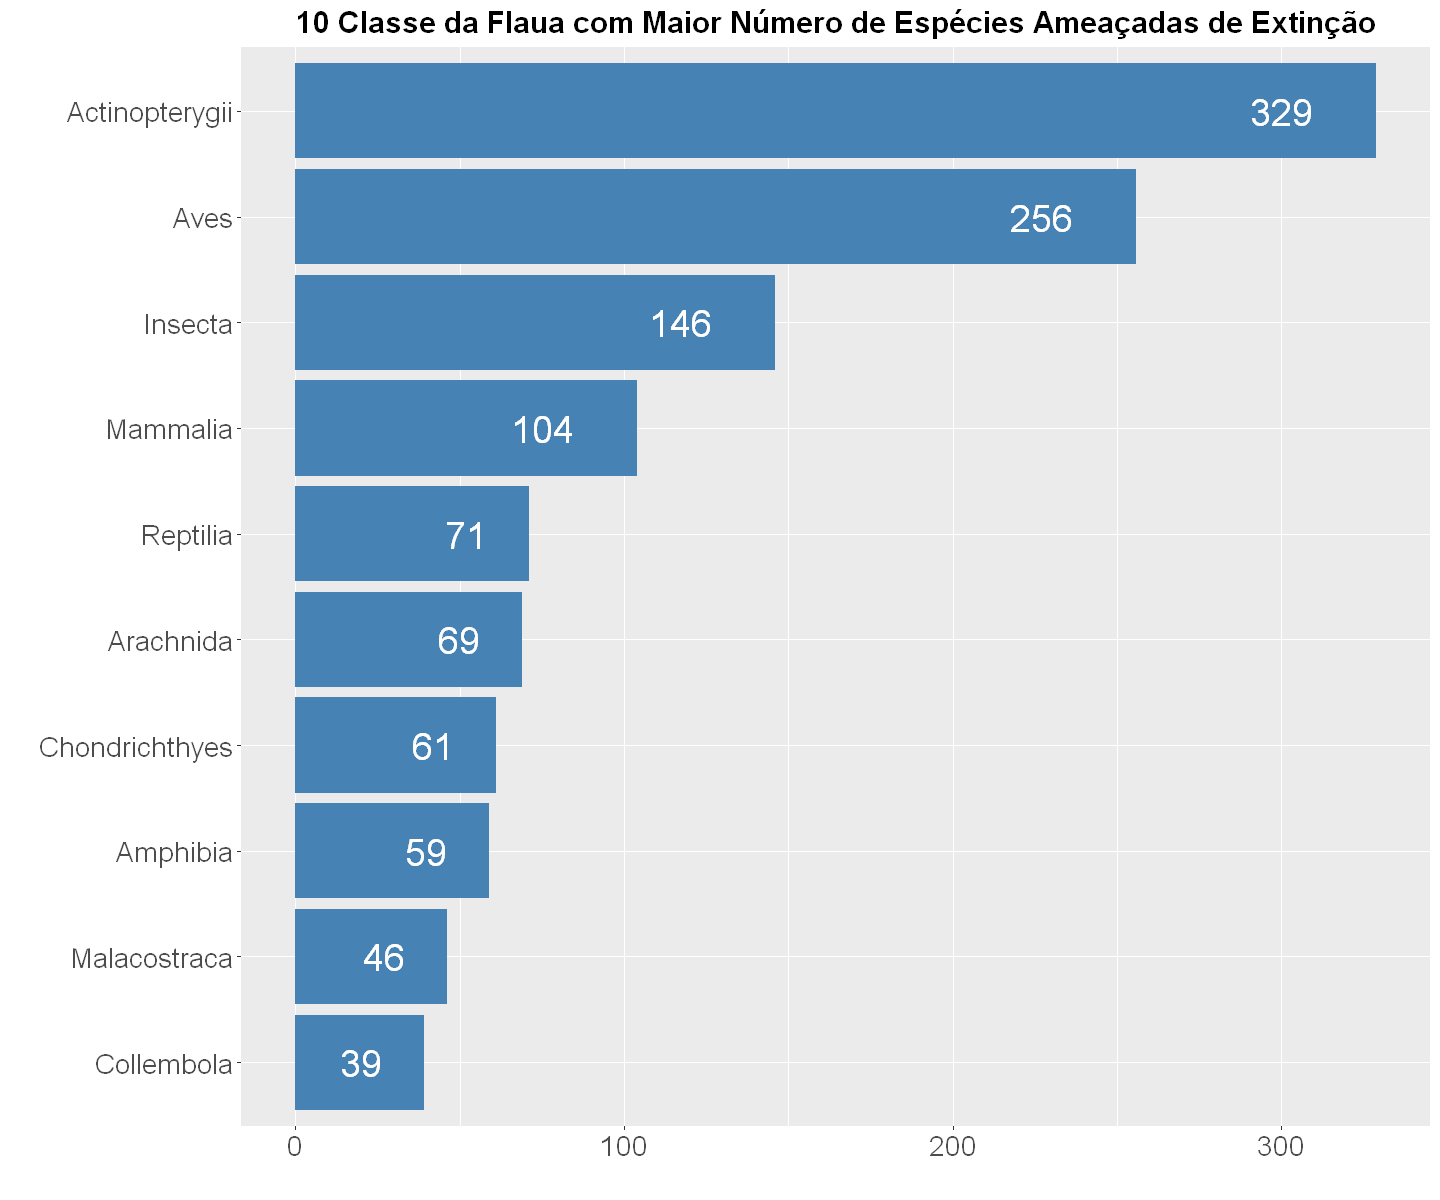

In [39]:
statusClass <- df %>%
        count(classe, sort = TRUE) %>%
        slice_max(n, n = 10)

statusClass$classe <- with(statusClass, reorder(classe, n))

ggplot(statusClass, aes(classe, n)) +
        geom_col(fill = 'steelblue') + coord_flip() +
        geom_text(aes(label = n, hjust = 2), color = 'white', size = 8) +
        my_theme +
        labs(
                title = '10 Classe da Flaua com Maior Número de Espécies Ameaçadas de Extinção',
                x = '',
                y = ''
            )

## 7.5 Quais Ordens Taxonômicas Possuem o Maior Número de Espécies Ameaçadas

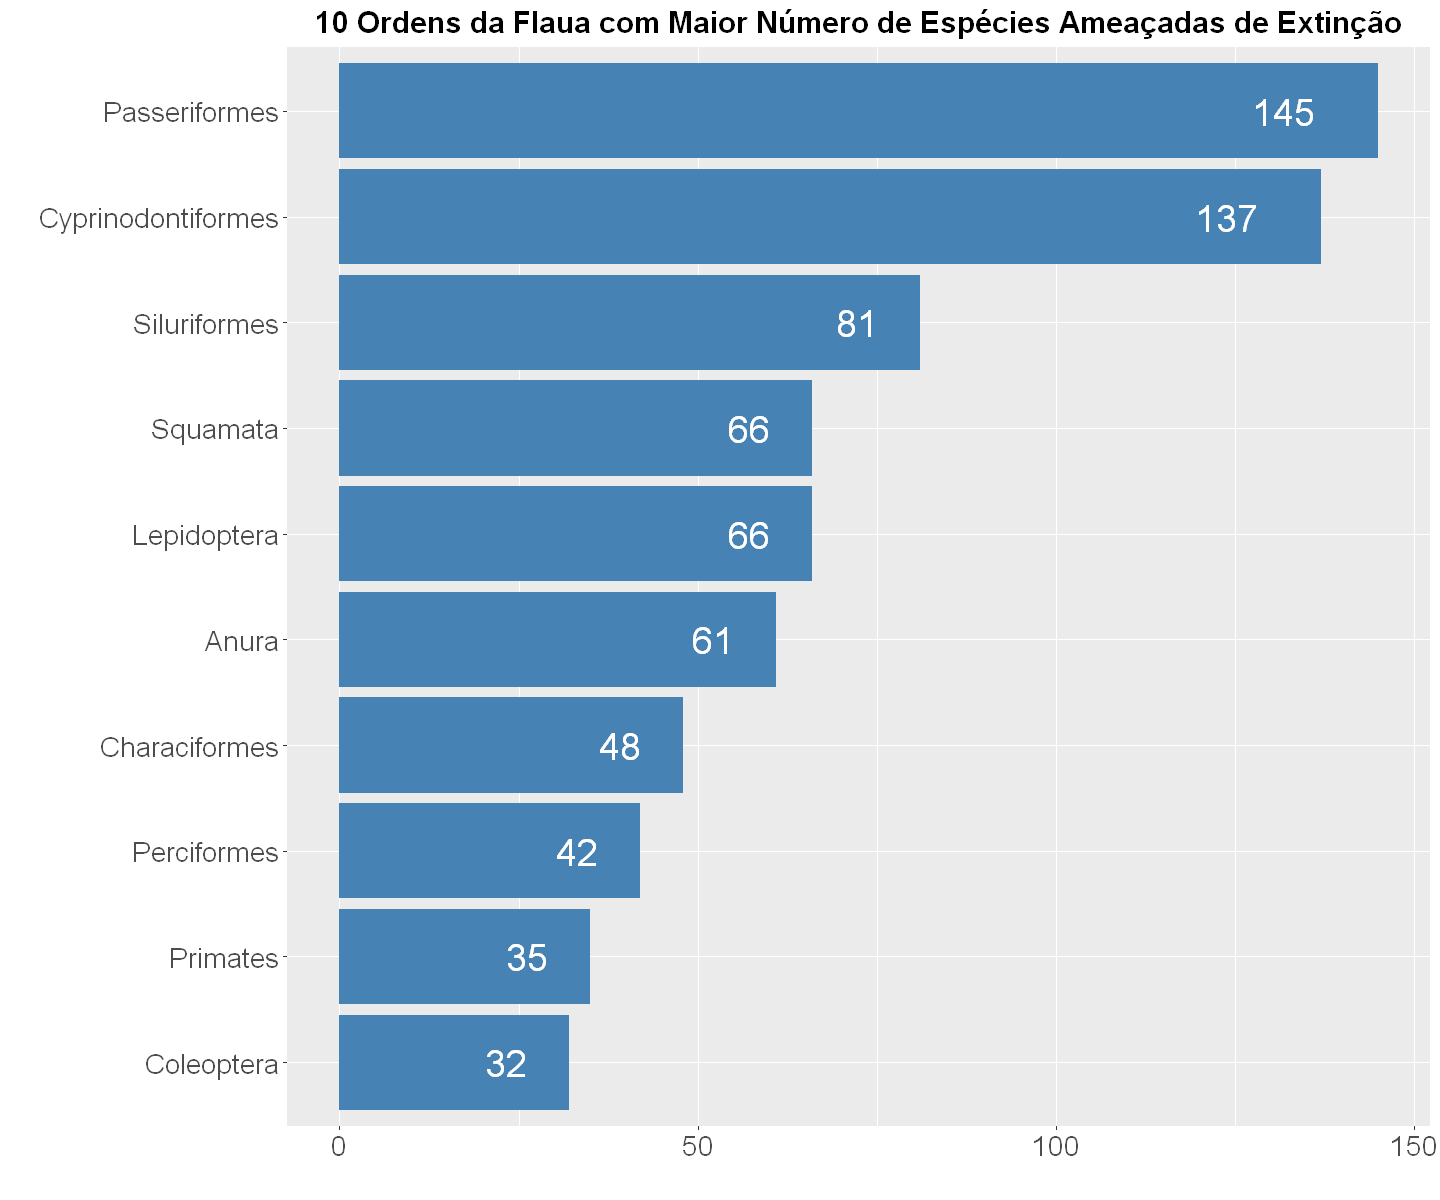

In [42]:
statusOrdem <- df %>%
        count(ordem, sort = TRUE) %>%
        slice_max(n, n = 10)

statusOrdem$ordem <- with(statusOrdem, reorder(ordem, n))

ggplot(statusOrdem, aes(ordem, n)) +
        geom_col(fill = 'steelblue') + coord_flip() +
        geom_text(aes(label = n, hjust = 2), color = 'white', size = 8) +
        my_theme +
        labs(
                title = '10 Ordens da Flaua com Maior Número de Espécies Ameaçadas de Extinção',
                x = '',
                y = ''
            )

## 7.6 Resumo dos Dados da Fauna Por Categoria de Ameaça

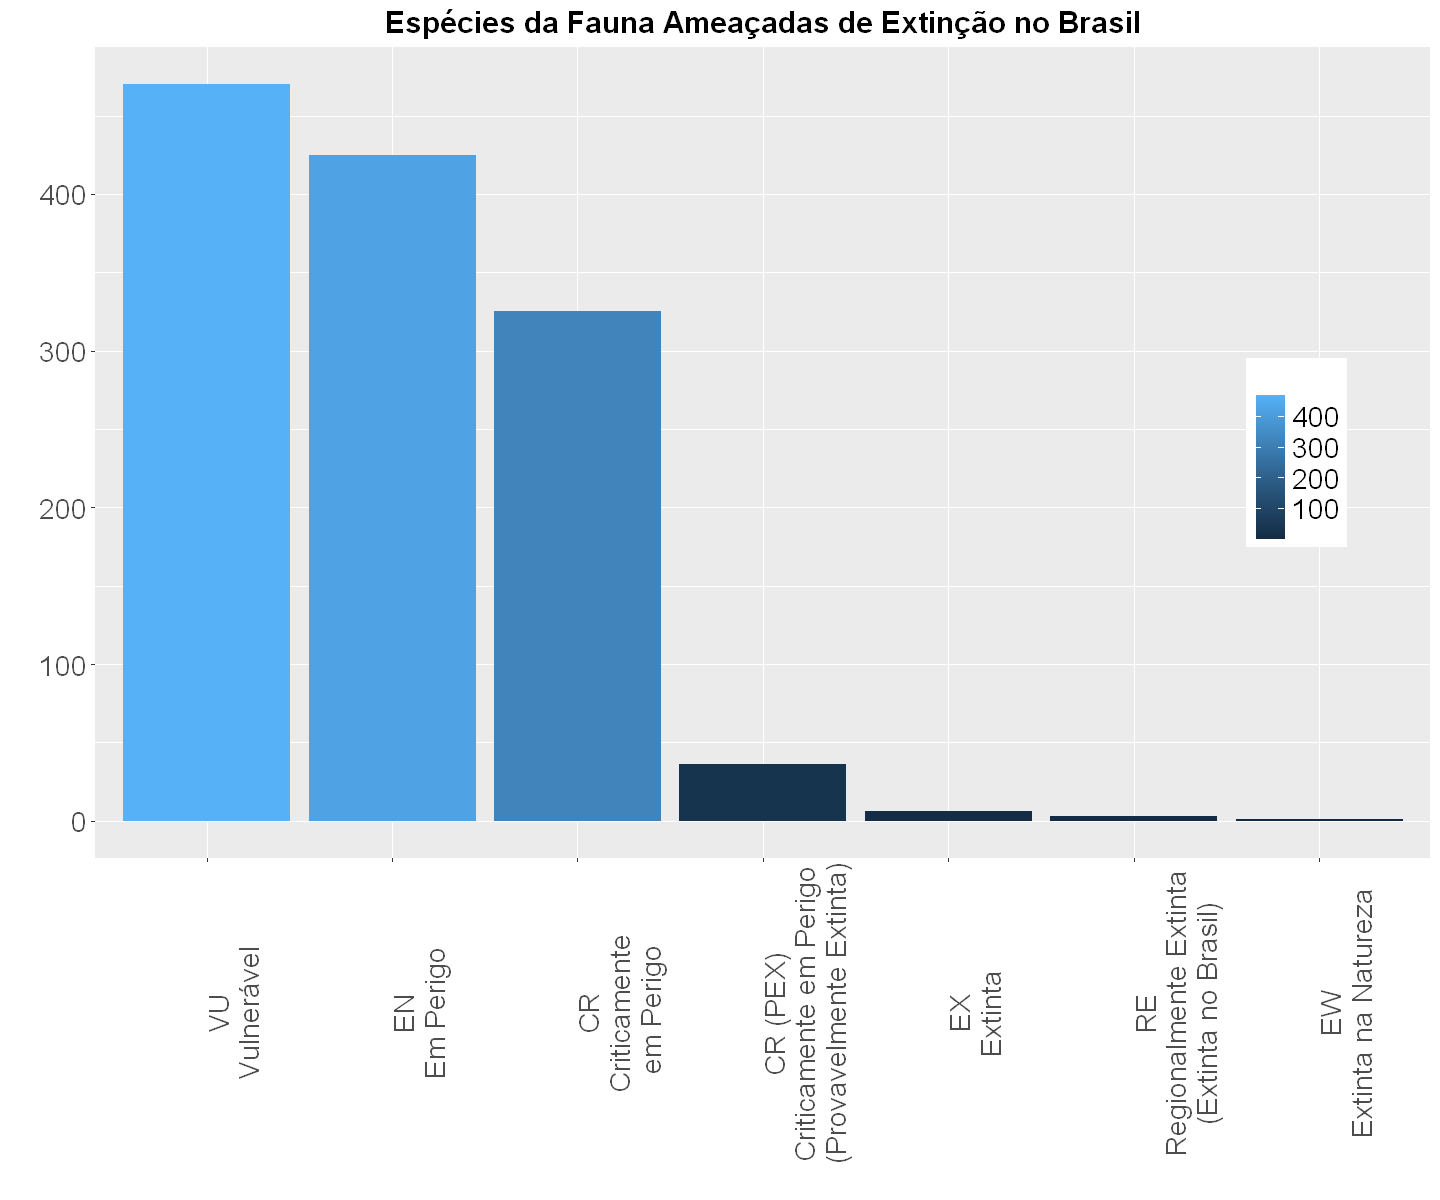

In [78]:
# Set status dataframe
species_status <- df %>%
        group_by(categoria) %>%
        count(categoria) %>%
        slice_max(n, n = 10)

# Reorder status dataframe by "n" and "categoria" columns
species_status$categoria <- with(species_status, reorder(categoria, n))

# Legend
labels <- c('VU\nVulnerável', 'EN\nEm Perigo', 'CR\nCriticamente\n em Perigo', 
            'CR (PEX)\nCriticamente em Perigo\n(Provavelmente Extinta)',
           'EX\nExtinta', 'RE\nRegionalmente Extinta\n(Extinta no Brasil)',
            'EW\nExtinta na Natureza')

status_cod <- c('VU', 'EN', 'CR' , 'CR (PEX)', 'EX', 'RE', 'EW')

# Status plot        
ggplot(species_status, aes(x = reorder(categoria, n, decreasing = F), n, fill = n)) +
    geom_col() +
    my_theme +
    theme(axis.text.x = element_text(angle = 90)) +
    scale_x_discrete(limits = status_cod, labels = labels) +
    labs(
            title = 'Espécies da Fauna Ameaçadas de Extinção no Brasil',
            x = '',
            y = '',
            fill = ''
    )